# Note: Please "Copy" this notebook before you work on it !!!!
In File   ->   Save a copy in Drive

# Author: Wenkang Wei
# email: wenkanw@g.clemson.edu

# 1.introduction

This project is about car classification for [stanford car dataset](https://ai.stanford.edu/~jkrause/cars/car_dataset.html). The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.

It is difficult to directly train deep learning model on this dataset because the limited number of images. Thus we decide to use transfer learning, a common approch used in deep learning to utilize the pretrained model on [imagenet](http://www.image-net.org/) and fine-tune on our own dataset, i.e. car dataset.

This project can show you how to train and fine-tune a deep learning model using kera (tensorflow backend).

![](https://ai.stanford.edu/~jkrause/cars/class_montage.jpg)

## 1.1 Transfer Learning
Transfer learning is one of the most widely used technologies in deep learning and computer vision. If you are not familar with the concept of transfer learning, please refer to our course materials.

![](https://cdn-images-1.medium.com/max/2000/1*9GTEzcO8KxxrfutmtsPs3Q.png)

# 2.Making a car classifier using Pytorch

In this notebook I'm making a car classifier using the Stanford car dataset, which contains 196 classes.
I'll be using a pre-trained model with transfer learning to train the model. All layers will be fine tuned and the last fully connected layer will be replaced entirely.

Dataset (196 classes):

Train folder: 8144 images, avg: 41.5 images per class.

Test folder: 8041 images, avg: 41.0 images per class.

## 2.1 mount google drive to colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Download row data

In [ ]:
# # download raw dataset
# ! wget http://imagenet.stanford.edu/internal/car196/cars_train.tgz
# ! wget http://imagenet.stanford.edu/internal/car196/cars_test.tgz
# ! wget http://imagenet.stanford.edu/internal/car196/cars_annos.mat

# #make directory
# !mkdir ./stanford_car_dataset_raw 
# # unzip dataset
# !tar -zxvf cars_train.tgz --directory=./stanford_car_dataset_raw 
# !tar -zxvf cars_test.tgz --directory=./stanford_car_dataset_raw 
# !mv  ./cars_annos.mat ./stanford_car_dataset_row/

# # ls 
# !ls ./stanford_car_dataset_raw /cars_train | wc -l 
# !ls ./stanford_car_dataset_raw /cars_test | wc -l 


#### Or we can Download Cleaned Data from google drive if we dont' need raw data

In [ ]:
# https://drive.google.com/file/d/1xgdUSH-G9B8YTiQZGmWyNxtoRtogE56x/view?usp=sharing
!gdown --id 1xgdUSH-G9B8YTiQZGmWyNxtoRtogE56x

Downloading...
From: https://drive.google.com/uc?id=1xgdUSH-G9B8YTiQZGmWyNxtoRtogE56x
To: /content/stanford_car_dataset.zip
1.96GB [00:16, 117MB/s]


## 2.2 Copy file from google drive to colab

In [ ]:
# copy dataset from google drive to colab. https://drive.google.com/open?id=1qcSFJ_2Ouom95QYDI3n498JEnqQd71vx
# !cp ./drive/My\ Drive/stanford_car_dataset.zip ./

In [ ]:
# !rm -rf ./stanford_car_dataset

## 2.3 Extract dataset files

In [ ]:
# %%time
# unzip dataset in colab
!mkdir ./stanford_car_dataset
!unzip -q stanford_car_dataset.zip -d ./stanford_car_dataset


#### Make a Copy to My Drive

In [ ]:
# ! cp -rf ./stanford_car_dataset /content/drive/My\ Drive/Colab\ Notebooks/laioffer-in-class-coding
# ! mkdir /content/drive/My\ Drive/Colab\ Notebooks/laioffer-in-class-coding/data
# ! mv  /content/drive/My\ Drive/Colab\ Notebooks/laioffer-in-class-coding/stanford_car_dataset /content/drive/My\ Drive/Colab\ Notebooks/laioffer-in-class-coding/data/

## Directly Copy data from Google Drive to Colab

In [ ]:
# Recommend to download data from link, it is much faster
# !cp -rf /content/drive/My\ Drive/Colab\ Notebooks/laioffer-in-class-coding/data/stanford_car_dataset ./

# 3.Build model

## 3.1 Load packages

The pytorch have been pre-installled on colab, and we do not need re-install these packages.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import time
import os
import tqdm
import PIL.Image as Image
from IPython.display import display

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
Tesla T4


## 3.2 Load the data and transform

First, lets create some transforms for our data and load the train/test data+labels from the folders.

Here we are using 224x224 images (you can also change the resolution) with random horizontal flip, random rotation and normalization

In [ ]:
dataset_dir = "stanford_car_dataset/car_data/car_data/"


# data transformation, you can try different transformation/ data augmentation here
# note: no data augmentation for test data

width, height = 224, 224
train_tfms = transforms.Compose([transforms.Resize((width, height)),
                                 # transforms.RandomHorizontalFlip(),
                                 # transforms.RandomRotation(15),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_tfms = transforms.Compose([transforms.Resize((width, height)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# create datasets
dataset = torchvision.datasets.ImageFolder(root=dataset_dir+"train", transform=train_tfms)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

dataset2 = torchvision.datasets.ImageFolder(root=dataset_dir+"test", transform = test_tfms)
testloader = torch.utils.data.DataLoader(dataset2, batch_size=32, shuffle=False, num_workers=2)


## 3.3 Model training function

Here we train our model, after each epoch, we test the model on the test data to see how it's going

In [ ]:
def train_model(model, criterion, optimizer, scheduler, n_epochs=5):
    
    losses = []
    accuracies = []
    test_accuracies = []

    # set the model to train mode initially
    model.train()
    for epoch in tqdm.tqdm(range(n_epochs)):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(trainloader, 0):

            # get the inputs and assign them to cuda
            inputs, labels = data
            #inputs = inputs.to(device).half() # uncomment for half precision model
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time() - since
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 / 32 * running_correct / len(trainloader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

## 3.4 Evaluate on training data
This function is called out after each epoch of training on the training data. We then measure the accuracy of the model.

In [ ]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data
            #images = images.to(device).half() # uncomment for half precision model
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (test_acc))
    return test_acc

# 4.Experiment

## 4.1 define parameters

In [ ]:
NUM_CAR_CLASSES = 196
model_ft = models.alexnet(pretrained=True)  # resnet34(pretrained=True)

# Freezing model parameters and defining the fully connected network to be attached to the model, 
# loss function and the optimizer.
# We there after put the model on the GPUs
# for param in model_ft.parameters():
#     param.require_grad = False

# replace the last fc layer with an untrained one (requires grad by default)

# for alexnet
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs, NUM_CAR_CLASSES)

# for resnet34
# num_ftrs = model_ft.fc.in_features
# model_ft.fc = nn.Linear(num_ftrs, NUM_CAR_CLASSES)

model_ft = model_ft.to(device)

# uncomment this block for half precision model
"""
model_ft = model_ft.half()


for layer in model_ft.modules():
    if isinstance(layer, nn.BatchNorm2d):
        layer.float()
"""
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

"""
probably not the best metric to track, but we are tracking the training accuracy and measuring whether
it increases by atleast 0.9 per epoch and if it hasn't increased by 0.9 reduce the lr by 0.1x.
However in this model it did not benefit me.
"""
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

## 4.2 model training

In [ ]:
model_ft, training_losses, training_accs, test_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=20)


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, duration: 114 s, loss: 5.2887, acc: 0.6618



  5%|▌         | 1/20 [03:42<1:10:26, 222.45s/it]

Accuracy of the network on the test images: 0 %
Epoch 2, duration: 111 s, loss: 5.2783, acc: 0.7721



 10%|█         | 2/20 [07:11<1:05:31, 218.43s/it]

Accuracy of the network on the test images: 0 %
Epoch 3, duration: 104 s, loss: 5.2694, acc: 0.7721



 15%|█▌        | 3/20 [10:34<1:00:34, 213.81s/it]

Accuracy of the network on the test images: 1 %
Epoch 4, duration: 105 s, loss: 5.2133, acc: 1.2990



 20%|██        | 4/20 [13:56<56:06, 210.38s/it]  

Accuracy of the network on the test images: 1 %
Epoch 5, duration: 88 s, loss: 5.0705, acc: 2.3897



 25%|██▌       | 5/20 [16:43<49:18, 197.23s/it]

Accuracy of the network on the test images: 4 %
Epoch 6, duration: 92 s, loss: 4.6120, acc: 6.5564



 30%|███       | 6/20 [19:45<44:55, 192.57s/it]

Accuracy of the network on the test images: 6 %
Epoch 7, duration: 100 s, loss: 4.0629, acc: 11.8873



 35%|███▌      | 7/20 [22:58<41:44, 192.69s/it]

Accuracy of the network on the test images: 12 %
Epoch 8, duration: 88 s, loss: 3.5729, acc: 18.4559



 40%|████      | 8/20 [25:48<37:10, 185.91s/it]

Accuracy of the network on the test images: 13 %
Epoch 9, duration: 83 s, loss: 3.1842, acc: 24.8652



 45%|████▌     | 9/20 [28:30<32:45, 178.73s/it]

Accuracy of the network on the test images: 16 %
Epoch 10, duration: 83 s, loss: 2.9424, acc: 29.5711



 50%|█████     | 10/20 [31:11<28:55, 173.53s/it]

Accuracy of the network on the test images: 18 %
Epoch 11, duration: 82 s, loss: 2.6049, acc: 35.3431



 55%|█████▌    | 11/20 [33:51<25:23, 169.31s/it]

Accuracy of the network on the test images: 19 %
Epoch 12, duration: 82 s, loss: 1.2906, acc: 64.4240



 60%|██████    | 12/20 [36:30<22:10, 166.32s/it]

Accuracy of the network on the test images: 30 %
Epoch 13, duration: 83 s, loss: 0.7239, acc: 79.0319



 65%|██████▌   | 13/20 [39:10<19:11, 164.50s/it]

Accuracy of the network on the test images: 32 %
Epoch 14, duration: 81 s, loss: 0.5068, acc: 84.8652



 70%|███████   | 14/20 [41:49<16:16, 162.76s/it]

Accuracy of the network on the test images: 33 %
Epoch 15, duration: 80 s, loss: 0.3566, acc: 88.8848



 75%|███████▌  | 15/20 [44:27<13:26, 161.39s/it]

Accuracy of the network on the test images: 34 %
Epoch 16, duration: 81 s, loss: 0.2826, acc: 90.8701



 80%|████████  | 16/20 [47:05<10:41, 160.44s/it]

Accuracy of the network on the test images: 35 %
Epoch 17, duration: 85 s, loss: 0.1811, acc: 94.5711



 85%|████████▌ | 17/20 [49:49<08:04, 161.34s/it]

Accuracy of the network on the test images: 35 %
Epoch 18, duration: 83 s, loss: 0.1710, acc: 94.6814



 90%|█████████ | 18/20 [52:36<05:26, 163.07s/it]

Accuracy of the network on the test images: 35 %
Epoch 19, duration: 88 s, loss: 0.1599, acc: 95.1471



 95%|█████████▌| 19/20 [55:27<02:45, 165.39s/it]

Accuracy of the network on the test images: 35 %
Epoch 20, duration: 87 s, loss: 0.1391, acc: 95.6250



100%|██████████| 20/20 [58:15<00:00, 174.76s/it]

Accuracy of the network on the test images: 35 %
Finished Training


## 4.3 As we can see the model reached 90% training accuracy by epoch 10.


Text(0.5, 1.0, 'Test acc')

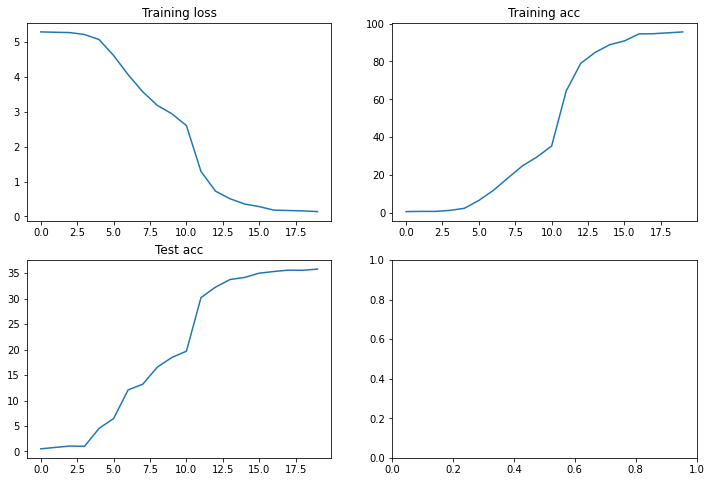

In [ ]:
# plot the stats

f, axarr = plt.subplots(2,2, figsize = (12, 8))
axarr[0, 0].plot(training_losses)
axarr[0, 0].set_title("Training loss")
axarr[0, 1].plot(training_accs)
axarr[0, 1].set_title("Training acc")
axarr[1, 0].plot(test_accs)

axarr[1, 0].set_title("Test acc")

## 4.4 Evaluate the model on single images (e.g for production)

Next we can use the model on our own images. For that we need to tie the class numbers for which the model returns probablities with the names of those classes.


In [ ]:
# tie the class indices to their names

def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes(dataset_dir+"train")

In [ ]:
# test the model on random images


# switch the model to evaluation mode to make dropout and batch norm work in eval mode
model_ft.eval()

# transforms for the input image
img_name = "test/Mercedes-Benz C-Class Sedan 2012/01977.jpg"
img_name = "test/AM General Hummer SUV 2000/00457.jpg"

loader = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
image = Image.open(dataset_dir + img_name)
image = loader(image).float()
image = torch.autograd.Variable(image, requires_grad=True)
image = image.unsqueeze(0)
image = image.cuda()
output = model_ft(image)
conf, predicted = torch.max(output.data, 1)

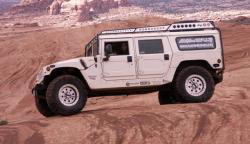

AM General Hummer SUV 2000 confidence:  11.224479675292969


In [ ]:
# get the class name of the prediction


display(Image.open(dataset_dir+img_name))
print(classes[predicted.item()], "confidence: ", conf.item())

# 5.Save and load model

In [ ]:
PATH = 'car_model.pth'
torch.save(model_ft.state_dict(), PATH)

In [ ]:
! mkdir /content/drive/My\ Drive/Colab\ Notebooks/laioffer-in-class-coding/data/models
!cp car_model.pth /content/drive/My\ Drive/Colab\ Notebooks/laioffer-in-class-coding/data/models/

In [ ]:
!ls /content/drive/My\ Drive/Colab\ Notebooks/laioffer-in-class-coding/data/models

car_model.pth


In [ ]:
model_loaded = torch.load(PATH)
model_loaded


OrderedDict([('features.0.weight',
              tensor([[[[ 1.1079e-01,  8.9380e-02,  9.1213e-02,  ...,  5.3974e-02,
                          1.6521e-02,  4.4646e-02],
                        [ 7.0441e-02,  2.4328e-02,  4.5817e-02,  ...,  2.4865e-02,
                         -1.0036e-02,  4.4818e-03],
                        [ 7.6840e-02,  3.1569e-02,  6.4488e-02,  ...,  4.5402e-02,
                          5.3673e-03,  6.8380e-03],
                        ...,
                        [ 9.9454e-02,  9.6946e-02,  5.9340e-02,  ..., -2.2549e-01,
                         -1.4668e-01, -1.1998e-01],
                        [ 4.3005e-02,  6.2148e-02,  4.2150e-02,  ..., -2.1568e-01,
                         -1.3308e-01, -1.1581e-01],
                        [ 5.8581e-02,  7.4523e-02,  5.5642e-02,  ..., -1.2401e-01,
                         -1.1118e-01, -9.0725e-02]],
              
                       [[-6.5003e-02, -5.1443e-02, -7.1564e-02,  ...,  1.6838e-03,
                         -2

#Extension: Using Other networks for transfer learning

# 1. Re-load Dataset and split training set into training set and validation set

In [ ]:
from sklearn.model_selection import train_test_split, ShuffleSplit


width, height = 224, 224
train_tfms = transforms.Compose([transforms.Resize((width, height)),
                                 # transforms.RandomHorizontalFlip(),
                                 # transforms.RandomRotation(15),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_tfms = transforms.Compose([transforms.Resize((width, height)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
# create datasets
dataset = torchvision.datasets.ImageFolder(root=dataset_dir+"train", transform=train_tfms)

# Split data into validatoin set and train set
val_split_ratio = 0.2
val_dataset, train_dataset = torch.utils.data.random_split(dataset, [int(val_split_ratio*len(dataset)), len(dataset)- int(val_split_ratio*len(dataset))], generator=torch.Generator().manual_seed(42))

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2)

# testing dataset
dataset2 = torchvision.datasets.ImageFolder(root=dataset_dir+"test", transform = test_tfms)
testloader = torch.utils.data.DataLoader(dataset2, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
len(val_dataset), len(train_dataset)

(1628, 6516)

# 1.1 Re-Write the train model and evaluation function

In [ ]:
def eval_model_v1(model,testloader=None):
    correct = 0.0
    total = 0.0
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data
            #images = images.to(device).half() # uncomment for half precision model
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (test_acc))
    return test_acc





def train_model_v1(model, criterion, optimizer, scheduler, n_epochs=5, trainloader= None, testloader =None,earlystopping=False,patience = 3):
    
    losses = []
    accuracies = []
    test_accuracies = []
    best_val_score = 0.0
    patience_count = 0
    # set the model to train mode initially
    best_model = None
    model.train()
    for epoch in tqdm.tqdm(range(n_epochs)):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(trainloader, 0):

            # get the inputs and assign them to cuda
            inputs, labels = data
            #inputs = inputs.to(device).half() # uncomment for half precision model
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time() - since
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 / 32 * running_correct / len(trainloader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_model_v1(model, testloader)
        test_accuracies.append(test_acc)
        if earlystopping:
          if test_acc > best_val_score:
            best_val_score = test_acc
            torch.save(model,"checkpoint.pt")
            patience_count = 0
            print("Checkpoint Saved")
          else:
            if patience_count < patience:
              patience_count += 1
            else:
              best_model = torch.load("checkpoint.pt")
              print("Load Best Model.")
              break



        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    # return the best model
    if not best_model:
      best_model = model

    return model,best_model, losses, accuracies, test_accuracies

# 2 Models Selection among GoogleNet, ResNet50, VGG16 to fine-tune

## 2.1 Using GoogleNet for transfer learning

In [ ]:
import torchvision.models as models

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class MyGoogleNet(nn.Module):
  def __init__(self, num_classes= 196,unfreeze_flag= True):
    super().__init__()
    googlenet = models.googlenet(pretrained=True)
    self.googlenet = googlenet
    #freezen network
    # self.googlenet.requires_grad_(False)
    for param in self.googlenet.parameters():
      param.require_grad = unfreeze_flag
    # Replace new layer    
    in_feature = self.googlenet.fc.in_features
    self.googlenet.fc = nn.Linear(in_feature, num_classes)
    self.googlenet.fc.apply(weights_init)

  def forward(self,x):
    return self.googlenet(x)
  
googlenet = MyGoogleNet().to(device)

In [ ]:
#define Loss function
googlenet_criterion = nn.CrossEntropyLoss()
#define optimizer: using Stochastic gradient descent
googlenet_optimizer = torch.optim.SGD(googlenet.parameters(),lr=0.1,weight_decay=0.001)
googlenet_lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(googlenet_optimizer,mode="max",factor=0.1,patience=3, threshold=0.9)

In [ ]:
googlenet_model, google_best_model ,googlenet_training_losses, googlenet_training_accs, googlenet_val_accs = train_model_v1(googlenet, googlenet_criterion, 
googlenet_optimizer, googlenet_lrscheduler, n_epochs=15,trainloader= trainloader, testloader= val_loader, earlystopping=True,patience=2)







  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1, duration: 66 s, loss: 4.5495, acc: 7.5674








  7%|▋         | 1/15 [01:20<18:52, 80.89s/it]

Accuracy of the network on the test images: 16 %
Checkpoint Saved
Epoch 2, duration: 66 s, loss: 2.6279, acc: 37.5613








 13%|█▎        | 2/15 [02:42<17:32, 80.97s/it]

Accuracy of the network on the test images: 22 %
Checkpoint Saved
Epoch 3, duration: 66 s, loss: 1.4522, acc: 64.8591








 20%|██        | 3/15 [04:03<16:13, 81.16s/it]

Accuracy of the network on the test images: 37 %
Checkpoint Saved
Epoch 4, duration: 66 s, loss: 0.8196, acc: 81.2806








 27%|██▋       | 4/15 [05:24<14:53, 81.20s/it]

Accuracy of the network on the test images: 53 %
Checkpoint Saved
Epoch 5, duration: 67 s, loss: 0.4432, acc: 91.6360








 33%|███▎      | 5/15 [06:47<13:35, 81.56s/it]

Accuracy of the network on the test images: 65 %
Checkpoint Saved
Epoch 6, duration: 66 s, loss: 0.2165, acc: 97.2886








 40%|████      | 6/15 [08:08<12:13, 81.55s/it]

Accuracy of the network on the test images: 68 %
Checkpoint Saved
Epoch 7, duration: 66 s, loss: 0.1186, acc: 98.8971








 47%|████▋     | 7/15 [09:30<10:52, 81.56s/it]

Accuracy of the network on the test images: 67 %
Epoch 8, duration: 66 s, loss: 0.0734, acc: 99.4945








 53%|█████▎    | 8/15 [10:51<09:30, 81.49s/it]

Accuracy of the network on the test images: 76 %
Checkpoint Saved
Epoch 9, duration: 66 s, loss: 0.0599, acc: 99.6477








 60%|██████    | 9/15 [12:13<08:08, 81.44s/it]

Accuracy of the network on the test images: 76 %
Checkpoint Saved
Epoch 10, duration: 66 s, loss: 0.0562, acc: 99.6936








 67%|██████▋   | 10/15 [13:34<06:46, 81.35s/it]

Accuracy of the network on the test images: 76 %
Checkpoint Saved
Epoch 11, duration: 66 s, loss: 0.0515, acc: 99.6477








 73%|███████▎  | 11/15 [14:55<05:24, 81.24s/it]

Accuracy of the network on the test images: 76 %
Epoch 12, duration: 65 s, loss: 0.0496, acc: 99.6477








 80%|████████  | 12/15 [16:16<04:03, 81.11s/it]

Accuracy of the network on the test images: 76 %
Checkpoint Saved
Epoch 13, duration: 66 s, loss: 0.0469, acc: 99.7089








 87%|████████▋ | 13/15 [17:37<02:42, 81.27s/it]

Accuracy of the network on the test images: 76 %
Epoch 14, duration: 66 s, loss: 0.0469, acc: 99.7243








 93%|█████████▎| 14/15 [18:58<01:21, 81.15s/it]

Accuracy of the network on the test images: 76 %
Epoch 15, duration: 65 s, loss: 0.0473, acc: 99.7243
Accuracy of the network on the test images: 76 %
Load Best Model.
Finished Training


## Plot Performance: Accuracy and Loss

Text(0.5, 1.0, 'Validation acc')

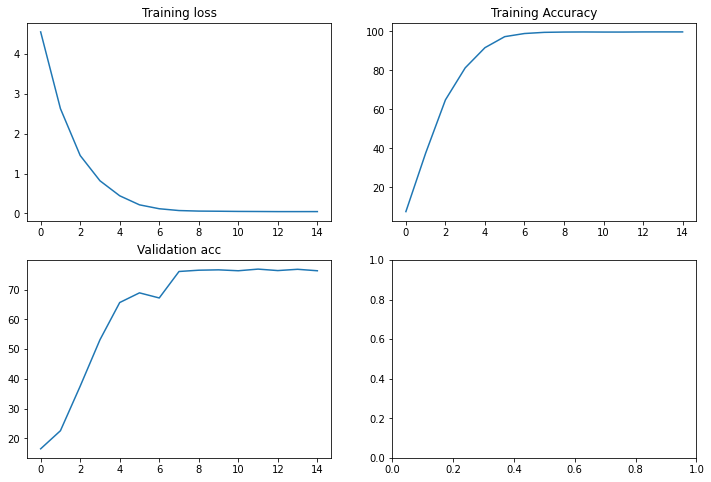

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(12,8))
ax[0, 0].plot(googlenet_training_losses)
ax[0, 0].set_title("Training loss")

ax[0, 1].plot(googlenet_training_accs)
ax[0, 1].set_title("Training Accuracy")

ax[1, 0].plot(googlenet_val_accs)
ax[1, 0].set_title("Validation acc")

# Test Accuracy of trained model on test set: 78%

In [ ]:
google_best_model.eval()
test_acc = eval_model_v1(google_best_model, testloader = testloader)
print("Test Accuracy: %d "%test_acc)

Accuracy of the network on the test images: 78 %
Test Accuracy: 78 


# Save Model

In [ ]:
! cp checkpoint.pt car_image_best_model.pt
! cp checkpoint.pt /content/drive/My\ Drive/Colab\ Notebooks/laioffer-in-class-coding/DS-HW/

# 2.2 ResNet50 Model for transfer learning

In [ ]:
import torchvision.models as models
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class MyResNet50(nn.Module):
  def __init__(self, num_classes= 196, unfreeze_flag= True):
    super().__init__()
    resnet50_model = models.resnet50(pretrained=True)
    self.resnet50_model = resnet50_model
    #freezen network
    for param in self.resnet50_model.parameters():
      param.require_grad = unfreeze_flag
    
    # Replace new layer    
    # layer = [,nn.Linear(2048, num_classes)]
    self.resnet50_model.fc = nn.Linear(2048, num_classes)
    self.resnet50_model.fc.apply(weights_init)
  def forward(self,x):
    out = self.resnet50_model(x)
  
    return out
  
resnet50_model = MyResNet50().to(device)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
#define Loss function
resnet_criterion = nn.CrossEntropyLoss()
#define optimizer: using Stochastic gradient descent
resnet_optimizer = torch.optim.SGD(resnet50_model.parameters(),lr=0.1,weight_decay=0.001)
resnet_lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(resnet_optimizer,mode="max",factor=0.1,patience=3, threshold=0.9)


In [ ]:
resnet_model, resnet_best_model,resnet_training_losses, resnet_training_accs, resnet_val_accs = train_model_v1(resnet50_model, resnet_criterion, 
                                                  resnet_optimizer, resnet_lrscheduler, n_epochs=10,
                                                  trainloader= trainloader, testloader= val_loader, 
                                                  earlystopping=True,patience=2)









  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, duration: 81 s, loss: 3.8886, acc: 13.6642
Accuracy of the network on the test images: 14 %










 10%|█         | 1/10 [01:37<14:39, 97.73s/it]

Checkpoint Saved
Epoch 2, duration: 82 s, loss: 1.8988, acc: 46.8444
Accuracy of the network on the test images: 34 %










 20%|██        | 2/10 [03:16<13:03, 97.96s/it]

Checkpoint Saved
Epoch 3, duration: 82 s, loss: 1.0313, acc: 69.6691










 30%|███       | 3/10 [04:54<11:26, 98.13s/it]

Accuracy of the network on the test images: 23 %
Epoch 4, duration: 83 s, loss: 0.5421, acc: 84.2065
Accuracy of the network on the test images: 50 %










 40%|████      | 4/10 [06:35<09:52, 98.83s/it]

Checkpoint Saved
Epoch 5, duration: 82 s, loss: 0.2638, acc: 93.1679










 50%|█████     | 5/10 [08:14<08:15, 99.07s/it]

Accuracy of the network on the test images: 38 %
Epoch 6, duration: 83 s, loss: 0.1250, acc: 97.3499
Accuracy of the network on the test images: 68 %










 60%|██████    | 6/10 [09:54<06:37, 99.31s/it]

Checkpoint Saved
Epoch 7, duration: 83 s, loss: 0.0500, acc: 99.1881
Accuracy of the network on the test images: 79 %










 70%|███████   | 7/10 [11:35<04:58, 99.64s/it]

Checkpoint Saved
Epoch 8, duration: 83 s, loss: 0.0229, acc: 99.6170
Accuracy of the network on the test images: 81 %










 80%|████████  | 8/10 [13:15<03:19, 99.79s/it]

Checkpoint Saved
Epoch 9, duration: 83 s, loss: 0.0172, acc: 99.6783
Accuracy of the network on the test images: 81 %










 90%|█████████ | 9/10 [14:55<01:39, 99.95s/it]

Checkpoint Saved
Epoch 10, duration: 82 s, loss: 0.0151, acc: 99.6783
Accuracy of the network on the test images: 81 %










100%|██████████| 10/10 [16:34<00:00, 99.49s/it]

Checkpoint Saved
Finished Training


## Plot Performance: Accuracy and Loss of ResNet50

Text(0.5, 1.0, 'Validation acc')

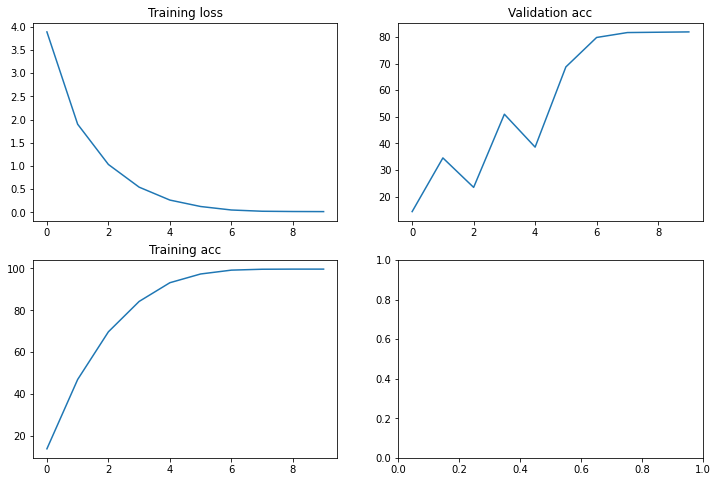

In [ ]:
#plot accuarcy
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,2, figsize=(12,8))
ax[0,0].plot(resnet_training_losses)
ax[0,0].set_title("Training loss")
ax[1,0].plot(resnet_training_accs)
ax[1,0].set_title("Training acc")
ax[0,1].plot(resnet_val_accs)
ax[0,1].set_title("Validation acc")

# Test Accuracy of ResNet5 on test set: 83%

In [ ]:

resnet_best_model.eval()
test_acc = eval_model_v1(resnet_best_model, testloader = testloader)
print("Test Accuracy: %d "%test_acc)

Accuracy of the network on the test images: 83 %
Test Accuracy: 83 


In [ ]:
! cp checkpoint.pt car_image_ResNet50_best_model.pt
! cp car_image_ResNet50_best_model.pt /content/drive/My\ Drive/Colab\ Notebooks/laioffer-in-class-coding/DS-HW/

# 2.3 VGG16 model for Transfer Learning

In [ ]:

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class MyVGG(nn.Module):
  def __init__(self,num_class=196, unfreeze_flag = True):
    super().__init__()
    self.vgg_model = models.vgg16(pretrained=True)
    # unfreeze / freeze parameters
    for param in self.vgg_model.parameters():
      param.require_grad =  unfreeze_flag
    # replace the last layer
    self.vgg_model.classifier[6]= nn.Linear(4096,num_class)
    # using initialize weight strategy
    self.vgg_model.classifier[6].apply(weights_init)

  def forward(self, x):
    return self.vgg_model(x)



In [ ]:
vgg_model = MyVGG()
vgg_model = vgg_model.to(device)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
# vgg_model.named_parameters

#define Loss function
vgg_criterion = nn.CrossEntropyLoss()
#define optimizer: using Stochastic gradient descent
vgg_optimizer = torch.optim.SGD(vgg_model.parameters(),lr=0.1,weight_decay=0.001)
vgg_lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(vgg_optimizer,mode="max",factor=0.1,patience=3, threshold=0.9)


In [ ]:
vgg_model, vgg_best_model,vgg_training_losses, vgg_training_accs, vgg_val_accs = train_model_v1(vgg_model, vgg_criterion, 
                                                  vgg_optimizer, vgg_lrscheduler, n_epochs=20,
                                                  trainloader= trainloader, testloader= val_loader, 
                                                  earlystopping=True,patience=2)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, duration: 90 s, loss: 5.2878, acc: 0.4749
Accuracy of the network on the test images: 0 %


  5%|▌         | 1/20 [01:49<34:48, 109.90s/it]

Checkpoint Saved
Epoch 2, duration: 94 s, loss: 5.2698, acc: 0.9651


 10%|█         | 2/20 [03:40<33:03, 110.21s/it]

Accuracy of the network on the test images: 0 %
Epoch 3, duration: 95 s, loss: 5.2088, acc: 1.5778
Accuracy of the network on the test images: 1 %


 15%|█▌        | 3/20 [05:35<31:33, 111.41s/it]

Checkpoint Saved
Epoch 4, duration: 95 s, loss: 5.1402, acc: 1.6085


 20%|██        | 4/20 [07:27<29:46, 111.66s/it]

Accuracy of the network on the test images: 0 %
Epoch 5, duration: 96 s, loss: 4.6973, acc: 3.7837
Accuracy of the network on the test images: 3 %


 25%|██▌       | 5/20 [09:22<28:10, 112.69s/it]

Checkpoint Saved
Epoch 6, duration: 96 s, loss: 4.2315, acc: 7.6746
Accuracy of the network on the test images: 8 %


 30%|███       | 6/20 [11:17<26:29, 113.51s/it]

Checkpoint Saved
Epoch 7, duration: 96 s, loss: 3.7069, acc: 13.4498


 35%|███▌      | 7/20 [13:10<24:32, 113.23s/it]

Accuracy of the network on the test images: 8 %
Epoch 8, duration: 96 s, loss: 3.3254, acc: 19.7457
Accuracy of the network on the test images: 17 %


 40%|████      | 8/20 [15:05<22:44, 113.72s/it]

Checkpoint Saved
Epoch 9, duration: 96 s, loss: 2.6359, acc: 30.4381
Accuracy of the network on the test images: 24 %


 45%|████▌     | 9/20 [17:00<20:55, 114.16s/it]

Checkpoint Saved
Epoch 10, duration: 96 s, loss: 2.1317, acc: 41.9884
Accuracy of the network on the test images: 32 %


 50%|█████     | 10/20 [18:56<19:06, 114.60s/it]

Checkpoint Saved
Epoch 11, duration: 96 s, loss: 1.8029, acc: 50.2604
Accuracy of the network on the test images: 37 %


 55%|█████▌    | 11/20 [20:51<17:13, 114.84s/it]

Checkpoint Saved
Epoch 12, duration: 96 s, loss: 1.5231, acc: 56.7708


 60%|██████    | 12/20 [22:44<15:14, 114.28s/it]

Accuracy of the network on the test images: 34 %
Epoch 13, duration: 96 s, loss: 1.1516, acc: 66.6973
Accuracy of the network on the test images: 43 %


 65%|██████▌   | 13/20 [24:40<13:23, 114.76s/it]

Checkpoint Saved
Epoch 14, duration: 96 s, loss: 0.9221, acc: 72.7941


 70%|███████   | 14/20 [26:34<11:26, 114.44s/it]

Accuracy of the network on the test images: 37 %
Epoch 15, duration: 96 s, loss: 0.7046, acc: 79.4271


 75%|███████▌  | 15/20 [28:26<09:29, 113.92s/it]

Accuracy of the network on the test images: 23 %
Epoch 16, duration: 96 s, loss: 0.2364, acc: 92.8002
Accuracy of the network on the test images: 61 %


 80%|████████  | 16/20 [30:22<07:37, 114.39s/it]

Checkpoint Saved
Epoch 17, duration: 96 s, loss: 0.0901, acc: 97.0435
Accuracy of the network on the test images: 63 %


 85%|████████▌ | 17/20 [32:18<05:44, 114.86s/it]

Checkpoint Saved
Epoch 18, duration: 96 s, loss: 0.0560, acc: 98.2077
Accuracy of the network on the test images: 63 %


 90%|█████████ | 18/20 [34:14<03:50, 115.29s/it]

Checkpoint Saved
Epoch 19, duration: 97 s, loss: 0.0546, acc: 98.0392
Accuracy of the network on the test images: 63 %


 95%|█████████▌| 19/20 [36:10<01:55, 115.57s/it]

Checkpoint Saved
Epoch 20, duration: 96 s, loss: 0.0339, acc: 98.9737
Accuracy of the network on the test images: 64 %


100%|██████████| 20/20 [38:06<00:00, 114.35s/it]

Checkpoint Saved
Finished Training


## Plot Performance: Accuracy and Loss of VGG16

Text(0.5, 1.0, 'Test acc')

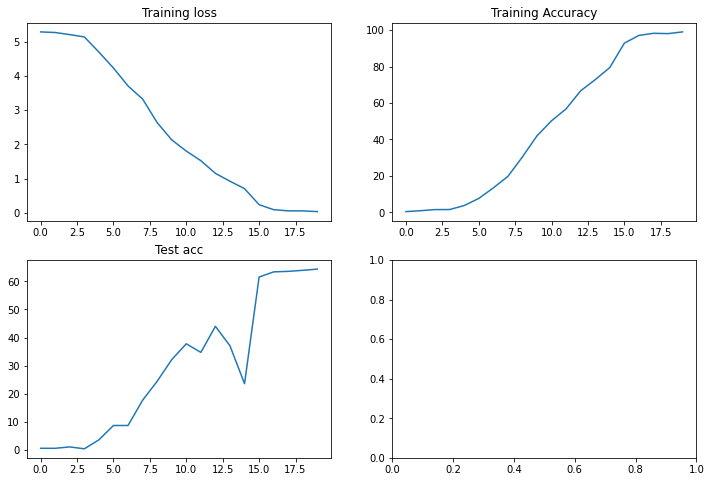

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(12,8))
ax[0, 0].plot(vgg_training_losses)
ax[0, 0].set_title("Training loss")

ax[0, 1].plot(vgg_training_accs)
ax[0, 1].set_title("Training Accuracy")

ax[1, 0].plot(vgg_val_accs)
ax[1, 0].set_title("Test acc")

From VGG learning curve, we can see that the model performance can be improved by using more epoches or higher learning, since the training accuracy has not converge yet.
So I decide to tune the model by changing learning rate here

In [ ]:
! cp checkpoint.pt car_image_VGG_best_model.pt
! cp car_image_VGG_best_model.pt /content/drive/My\ Drive/Colab\ Notebooks/laioffer-in-class-coding/DS-HW/

# Test Accuracy of VGG16 on test set: 65%

In [ ]:

vgg_best_model.eval()
test_acc = eval_model_v1(vgg_best_model, testloader = testloader)
print("Test Accuracy: %d "%test_acc)

Accuracy of the network on the test images: 65 %
Test Accuracy: 65 


# Save model

In [ ]:
! cp checkpoint.pt car_image_VGG_best_model.pt
! cp car_image_VGG_best_model.pt /content/drive/My\ Drive/Colab\ Notebooks/laioffer-in-class-coding/DS-HW/

# Select model:
We can see that in the 4 models I tried for transfer learning, ResNet50 has the best testing accuracy performance 83%, with the least amount of epoches (10 epoches) to converge, while other models need more than 10 epoches to converge and have worse test accuracy
Hence, I choose to tune ResNet50 to get a better performance here

In [ ]:
! cp /content/drive/My\ Drive/Colab\ Notebooks/laioffer-in-class-coding/DS-HW/TransferLearning/car_image_* ./

In [ ]:
import torchvision.models as models
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class MyResNet50(nn.Module):
  def __init__(self, num_classes= 196, unfreeze_flag= True):
    super().__init__()
    resnet50_model = models.resnet50(pretrained=True)
    self.resnet50_model = resnet50_model
    #freezen network
    for param in self.resnet50_model.parameters():
      param.require_grad = unfreeze_flag
    
    # Replace new layer    
    # layer = [,nn.Linear(2048, num_classes)]
    self.resnet50_model.fc = nn.Linear(2048, num_classes)
    self.resnet50_model.fc.apply(weights_init)
  def forward(self,x):
    out = self.resnet50_model(x)
  
    return out
  

In [ ]:
# Load trained ResNet50 model
resnet_model = torch.load("car_image_ResNet50_best_model.pt")

# 3. Fine Tune the selected ResNet50 model
+ load data and transform images with flip, rotation normalize operations
+ split training set and validation set and test set

## 3.1 Data Loading and Transformation

In [ ]:
from sklearn.model_selection import train_test_split, ShuffleSplit
width, height = 224, 224
train_tfms = transforms.Compose([transforms.Resize((width, height)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(15),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.5, 0.5, 0.5], [0.229, 0.224, 0.225])])
test_tfms = transforms.Compose([transforms.Resize((width, height)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5, 0.5, 0.5], [0.229, 0.224, 0.225])])
# create datasets
dataset = torchvision.datasets.ImageFolder(root=dataset_dir+"train", transform=train_tfms)

# Split data into validatoin set and train set
val_split_ratio = 0.2
val_dataset, train_dataset = torch.utils.data.random_split(dataset, [int(val_split_ratio*len(dataset)), len(dataset)- int(val_split_ratio*len(dataset))], generator=torch.Generator().manual_seed(42))

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2)

# testing dataset
dataset2 = torchvision.datasets.ImageFolder(root=dataset_dir+"test", transform = test_tfms)
testloader = torch.utils.data.DataLoader(dataset2, batch_size=32, shuffle=False, num_workers=2)

# 3.2 Train model

In [ ]:
#define Loss function
resnet_criterion = nn.CrossEntropyLoss()
#define optimizer: using Stochastic gradient descent
resnet_optimizer = torch.optim.SGD(resnet_model.parameters(),lr=0.01,weight_decay=0.001)
resnet_lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(resnet_optimizer,mode="max",factor=0.1,patience=3, threshold=0.9)


In [ ]:

resnet_model, resnet_best_model,resnet_training_losses, resnet_training_accs, resnet_val_accs = train_model_v1(resnet_model, resnet_criterion, 
                                                  resnet_optimizer, resnet_lrscheduler, n_epochs=10,
                                                  trainloader= trainloader, testloader= val_loader, 
                                                  earlystopping=True,patience=2)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, duration: 85 s, loss: 0.2371, acc: 94.8070
Accuracy of the network on the test images: 81 %


 10%|█         | 1/10 [01:43<15:29, 103.31s/it]

Checkpoint Saved
Epoch 2, duration: 83 s, loss: 0.1820, acc: 96.1091


 20%|██        | 2/10 [03:23<13:39, 102.44s/it]

Accuracy of the network on the test images: 81 %
Epoch 3, duration: 83 s, loss: 0.1495, acc: 96.9363
Accuracy of the network on the test images: 81 %


 30%|███       | 3/10 [05:04<11:52, 101.81s/it]

Checkpoint Saved
Epoch 4, duration: 82 s, loss: 0.1325, acc: 97.5490
Accuracy of the network on the test images: 82 %


 40%|████      | 4/10 [06:43<10:07, 101.17s/it]

Checkpoint Saved
Epoch 5, duration: 83 s, loss: 0.1106, acc: 98.2230


 50%|█████     | 5/10 [08:23<08:24, 100.88s/it]

Accuracy of the network on the test images: 81 %
Epoch 6, duration: 83 s, loss: 0.0963, acc: 98.8051


 60%|██████    | 6/10 [10:04<06:42, 100.64s/it]

Accuracy of the network on the test images: 82 %
Epoch 7, duration: 83 s, loss: 0.0937, acc: 98.6213
Accuracy of the network on the test images: 83 %


 70%|███████   | 7/10 [11:44<05:01, 100.53s/it]

Checkpoint Saved
Epoch 8, duration: 83 s, loss: 0.0897, acc: 98.7132
Accuracy of the network on the test images: 83 %


 80%|████████  | 8/10 [13:24<03:20, 100.49s/it]

Checkpoint Saved
Epoch 9, duration: 83 s, loss: 0.0897, acc: 98.7898


 90%|█████████ | 9/10 [15:04<01:40, 100.31s/it]

Accuracy of the network on the test images: 83 %
Epoch 10, duration: 82 s, loss: 0.0866, acc: 98.7898


100%|██████████| 10/10 [16:44<00:00, 100.41s/it]

Accuracy of the network on the test images: 82 %
Finished Training


# Test Accuracy without using cross-validation: 84%

In [ ]:

resnet_best_model.eval()
test_acc = eval_model_v1(resnet_best_model, testloader = testloader)
print("Test Accuracy: %d "%test_acc)

Accuracy of the network on the test images: 84 %
Test Accuracy: 84 


In [ ]:
! cp checkpoint.pt car_image_Tuned_ResNet50_best_model.pt
! cp car_image_Tuned_ResNet50_best_model.pt /content/drive/My\ Drive/Colab\ Notebooks/laioffer-in-class-coding/DS-HW/

# 3.3. 4-Fold Cross Validation for ResNet50 model to select better parameters

In [ ]:
def K_fold_cv( dataset, model,k = 5):
  training_loss_ls = []
  training_acc_ls = []
  val_acc_list = []
  model_ls = []
  
  print("Start %d Cross Validation"%(k))
  print()
  # create datasets
  dataset = torchvision.datasets.ImageFolder(root=dataset_dir+"train", transform=train_tfms)

  # Split data into validatoin set and train set
  fold_size = len(dataset)//k
  #create fold indices
  fold_list = [fold_size]*(k-1)
  fold_list.append(len(dataset) - (k-1)*fold_size)
  folds_data = torch.utils.data.random_split(dataset, fold_list, generator=torch.Generator().manual_seed(42))
  # print(folds_data)
  max_val_score = 0
  best_model = None
  for valid_index in range(k):
    # re-initialize model
    model = torch.load("car_image_ResNet50_best_model.pt")
    #define Loss function
    resnet_criterion = nn.CrossEntropyLoss()
    #define optimizer: using Stochastic gradient descent
    resnet_optimizer = torch.optim.SGD(model.parameters(),lr=0.01,weight_decay=0.001)
    resnet_lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(resnet_optimizer,mode="max",factor=0.1,patience=3, threshold=0.9)


    print("Validation Fold: %d"%(valid_index))
    print()
    valid_dataset = folds_data.pop(valid_index)
    fold_val_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True, num_workers=2)
    traindata = torch.utils.data.ConcatDataset(folds_data)
    fold_trainloader = torch.utils.data.DataLoader(traindata, batch_size=32, shuffle=True, num_workers=2)
    # add the validation dataset back to original position
    folds_data.insert(valid_index, valid_dataset)
    
    
    # train data
    
    resnet_model, resnet_best_model,resnet_training_losses, resnet_training_accs, resnet_val_accs = train_model_v1(model, resnet_criterion, 
                                                  resnet_optimizer, resnet_lrscheduler, n_epochs=10,
                                                  trainloader= fold_trainloader, testloader= fold_val_loader, 
                                                  earlystopping=True,patience=2)
    training_loss_ls.append(resnet_training_losses)
    training_acc_ls.append(resnet_training_accs)
    val_acc_list.append(resnet_val_accs)
    model_ls.append(resnet_best_model)
    #update model 
    if max_val_score < max(resnet_val_accs):
      best_model = resnet_best_model
      max_val_score = max(resnet_val_accs)
    print("Completed Fold:%d"%(valid_index))
    print()
  return best_model, training_loss_ls, training_acc_ls,val_acc_list,model_ls


best_model, training_loss_ls, training_acc_ls,val_acc_list,model_ls = K_fold_cv(dataset, model=resnet_model,k=4)












  0%|          | 0/10 [00:00<?, ?it/s]

Start 4 Cross Validation

Validation Fold: 0

Epoch 1, duration: 82 s, loss: 0.2476, acc: 94.2408
Accuracy of the network on the test images: 82 %













 10%|█         | 1/10 [01:44<15:42, 104.71s/it]

Checkpoint Saved
Epoch 2, duration: 82 s, loss: 0.1784, acc: 96.6296
Accuracy of the network on the test images: 84 %













 20%|██        | 2/10 [03:28<13:55, 104.50s/it]

Checkpoint Saved
Epoch 3, duration: 81 s, loss: 0.1439, acc: 97.4967













 30%|███       | 3/10 [05:11<12:07, 103.97s/it]

Accuracy of the network on the test images: 84 %
Epoch 4, duration: 82 s, loss: 0.1321, acc: 97.8403













 40%|████      | 4/10 [06:55<10:24, 104.10s/it]

Accuracy of the network on the test images: 84 %
Epoch 5, duration: 81 s, loss: 0.1153, acc: 98.2166
Accuracy of the network on the test images: 84 %
Load Best Model.
Finished Training
Completed Fold:0















  0%|          | 0/10 [00:00<?, ?it/s]

Validation Fold: 1

Epoch 1, duration: 80 s, loss: 0.4119, acc: 90.1505
Accuracy of the network on the test images: 96 %














 10%|█         | 1/10 [01:43<15:33, 103.72s/it]

Checkpoint Saved
Epoch 2, duration: 80 s, loss: 0.2985, acc: 93.1119
Accuracy of the network on the test images: 96 %














 20%|██        | 2/10 [03:27<13:50, 103.83s/it]

Checkpoint Saved
Epoch 3, duration: 81 s, loss: 0.2321, acc: 95.0262














 30%|███       | 3/10 [05:13<12:09, 104.27s/it]

Accuracy of the network on the test images: 96 %
Epoch 4, duration: 81 s, loss: 0.1963, acc: 96.2369
Accuracy of the network on the test images: 96 %














 40%|████      | 4/10 [06:58<10:27, 104.54s/it]

Checkpoint Saved
Epoch 5, duration: 81 s, loss: 0.1729, acc: 96.5641














 50%|█████     | 5/10 [08:43<08:43, 104.60s/it]

Accuracy of the network on the test images: 96 %
Epoch 6, duration: 81 s, loss: 0.1395, acc: 97.7421
Accuracy of the network on the test images: 97 %














 60%|██████    | 6/10 [10:28<06:59, 104.98s/it]

Checkpoint Saved
Epoch 7, duration: 81 s, loss: 0.1322, acc: 97.7749
Accuracy of the network on the test images: 97 %














 70%|███████   | 7/10 [12:14<05:15, 105.19s/it]

Checkpoint Saved
Epoch 8, duration: 82 s, loss: 0.1323, acc: 98.0857














 80%|████████  | 8/10 [14:01<03:31, 105.79s/it]

Accuracy of the network on the test images: 96 %
Epoch 9, duration: 83 s, loss: 0.1230, acc: 98.3475














 90%|█████████ | 9/10 [15:49<01:46, 106.31s/it]

Accuracy of the network on the test images: 96 %
Epoch 10, duration: 82 s, loss: 0.1241, acc: 98.2166















  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the network on the test images: 97 %
Load Best Model.
Finished Training
Completed Fold:1

Validation Fold: 2



Epoch 1, duration: 84 s, loss: 0.4005, acc: 90.4614
Accuracy of the network on the test images: 95 %















 10%|█         | 1/10 [01:47<16:04, 107.13s/it]

Checkpoint Saved
Epoch 2, duration: 83 s, loss: 0.2974, acc: 93.1774















 20%|██        | 2/10 [03:33<14:15, 106.98s/it]

Accuracy of the network on the test images: 95 %
Epoch 3, duration: 83 s, loss: 0.2339, acc: 94.7808
Accuracy of the network on the test images: 96 %















 30%|███       | 3/10 [05:20<12:27, 106.78s/it]

Checkpoint Saved
Epoch 4, duration: 84 s, loss: 0.1945, acc: 96.1551















 40%|████      | 4/10 [07:06<10:40, 106.74s/it]

Accuracy of the network on the test images: 96 %
Epoch 5, duration: 84 s, loss: 0.1696, acc: 96.8423
Accuracy of the network on the test images: 96 %















 50%|█████     | 5/10 [08:54<08:54, 106.92s/it]

Checkpoint Saved
Epoch 6, duration: 85 s, loss: 0.1429, acc: 97.5622















 60%|██████    | 6/10 [10:41<07:08, 107.18s/it]

Accuracy of the network on the test images: 96 %
Epoch 7, duration: 84 s, loss: 0.1313, acc: 97.9385















 70%|███████   | 7/10 [12:29<05:21, 107.20s/it]

Accuracy of the network on the test images: 96 %
Epoch 8, duration: 84 s, loss: 0.1239, acc: 98.0857
Accuracy of the network on the test images: 97 %















 80%|████████  | 8/10 [14:17<03:34, 107.44s/it]

Checkpoint Saved
Epoch 9, duration: 85 s, loss: 0.1254, acc: 98.2984















 90%|█████████ | 9/10 [16:05<01:47, 107.62s/it]

Accuracy of the network on the test images: 96 %
Epoch 10, duration: 84 s, loss: 0.1311, acc: 97.8240















100%|██████████| 10/10 [17:52<00:00, 107.26s/it]













  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the network on the test images: 97 %
Finished Training
Completed Fold:2

Validation Fold: 3

Epoch 1, duration: 84 s, loss: 0.4067, acc: 89.9705
Accuracy of the network on the test images: 96 %















 10%|█         | 1/10 [01:48<16:15, 108.40s/it]

Checkpoint Saved
Epoch 2, duration: 83 s, loss: 0.3063, acc: 92.8501















 20%|██        | 2/10 [03:35<14:23, 107.89s/it]

Accuracy of the network on the test images: 96 %
Epoch 3, duration: 84 s, loss: 0.2351, acc: 94.9771
Accuracy of the network on the test images: 96 %















 30%|███       | 3/10 [05:22<12:34, 107.86s/it]

Checkpoint Saved
Epoch 4, duration: 83 s, loss: 0.2040, acc: 95.9097
Accuracy of the network on the test images: 96 %















 40%|████      | 4/10 [07:09<10:45, 107.53s/it]

Checkpoint Saved
Epoch 5, duration: 82 s, loss: 0.1712, acc: 96.6459
Accuracy of the network on the test images: 96 %















 50%|█████     | 5/10 [08:55<08:55, 107.04s/it]

Checkpoint Saved
Epoch 6, duration: 83 s, loss: 0.1377, acc: 97.7585















 60%|██████    | 6/10 [10:42<07:07, 106.89s/it]

Accuracy of the network on the test images: 96 %
Epoch 7, duration: 84 s, loss: 0.1320, acc: 97.8730
Accuracy of the network on the test images: 97 %















 70%|███████   | 7/10 [12:29<05:21, 107.00s/it]

Checkpoint Saved
Epoch 8, duration: 83 s, loss: 0.1253, acc: 98.2821















 80%|████████  | 8/10 [14:15<03:33, 106.83s/it]

Accuracy of the network on the test images: 97 %
Epoch 9, duration: 82 s, loss: 0.1236, acc: 98.1185















 90%|█████████ | 9/10 [16:02<01:46, 106.68s/it]

Accuracy of the network on the test images: 97 %
Epoch 10, duration: 84 s, loss: 0.1200, acc: 98.2166
Accuracy of the network on the test images: 96 %
Load Best Model.
Finished Training
Completed Fold:3



In [ ]:
torch.save(best_model, "car_image_OverallBest_model.pt")

! cp car_image_OverallBest_model.pt /content/drive/My\ Drive/Colab\ Notebooks/laioffer-in-class-coding/DS-HW/

# Test Accuracy on Test Set after 4-Fold CrossValidation on ResNet50: 85%

In [ ]:

best_model.eval()
test_acc = eval_model_v1(best_model, testloader = testloader)
print("Test Accuracy: %d "%test_acc)

Accuracy of the network on the test images: 85 %
Test Accuracy: 85 


Text(0.5, 1.0, 'Validation acc')

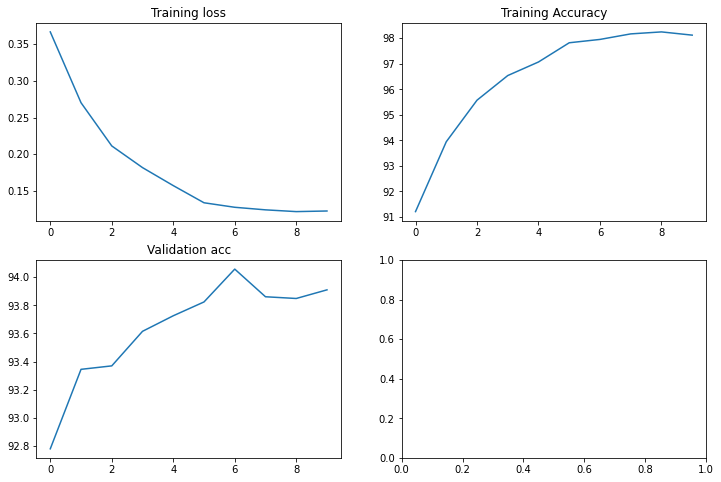

In [ ]:
import numpy as np
fig,ax = plt.subplots(2,2, figsize=(12,8))


def compute_CV_mean_loss(ls,k = 4,epoch=10):
  result = []
  for e in range(epoch):
    val = 00
    for i in range(k):
      if e < len(ls[i]):
        val += ls[i][e]
      else:
        val += ls[i][-1]
    val /= k
    result.append(val)
  return result


# Compute mean loss and accuracy from 4-fold cross validation data
mean_resnet_train_acc =compute_CV_mean_loss( training_acc_ls,k = 4,epoch=10)
mean_resnet_train_loss =compute_CV_mean_loss( training_loss_ls,k = 4,epoch=10)
mean_resnet_val_loss =compute_CV_mean_loss( val_acc_list,k = 4,epoch=10)


ax[0, 0].plot(mean_resnet_train_loss)
ax[0, 0].set_title("Training loss")

ax[0, 1].plot(mean_resnet_train_acc)
ax[0, 1].set_title("Training Accuracy")

ax[1, 0].plot(mean_resnet_val_loss)
ax[1, 0].set_title("Validation acc")


# 4. Report
### Data Collection
The dataset is 1.9GB car dataset from stanford data sources. There are 196 classes and 8144 training images and 8041 testing images in this dataset. The goal of this project is to apply transfer learning to borrow pre-trained  deep learning model to learn the car dataset

### Data Extract, Transform and Load (ETL)
1. Data Extraction
the 1.9GB dataset is downloaded directly from a cleaned data source in google drive. In the data folder, there are 196 sub-folders in both training set folder and testing set folder indicating 196 classes in dataset
2. Transformation
After extracting data, I use transformer tools, like ImageFolder, transformer  from PyTorch to load and resize the training and testing images into 3x224x224 RGB images with normalization.

3. Load data
After transformation of images, I use DataLoader tool in pytorch to convert dataset into a data loader with batch size = 32 and shuffle function enabled so that when training dataset, the data from iterator of loader contain a batch of samples with size of 32

### Model Selection in Transfer learning
When Selecting pre-trained model for transfer learning, I consider Alexnet, GoogleNet, ResNet50, VGG16. All of these models are transfer except the last Linear Layer. All transfer layers are unfroze during training.

During training step, I simply split the training set into 20% validation set and 80% training set to train and validate the model performance with evaluation metric of accuracy.
The 20% validation set is to small dataset to validate the performance of models and test the model on unseen dataset to see if the model is overfitting.

For model training, I unfreeze all network models and use SGD stochastic gradient descent optimizer to  tune model with learning rate =0.01  for AlexNet (as default) and 0.1 for GoogleNet, ResNet50 and VGG16, momentum =0.9 as default. In learning rate scheduler, I set patience to ignore the non-improved epoches as 3 with threshold of signifcant improvement of accuracy as 0.9%.
Moreover, the weight decay =0.001 (regularization term) is added to reduce overfitting.


The reason why I don't set the learning rate of AlexNet to 0.1 is that in the plot of the loss and accuracy on AlexNet show that when accuracy converges to 100%, validation accuracy also converges to about 35% without falling. That is, there is no overfitting making validation accuracy drops, but the model can not learn better attributes from data already. So rather than tuning this model, I choose to tune another three networks instead.

Performance Result
1. AlexNet
  + Test Accuracy on test set: 35%
  + With 20 epoches to converge
2. GoogleNet
  + Test Accuracy on test set: 78%
  + With 10 epoches to converge
3. ResNet50
  + Test Accuracy on test set: 83%
  + With 10 epoches to converge
4. VGG16
  + Test Accuracy on test set: 65%
  + With 20 epoches to converge

Based on the performance above, I find the ResNet50 model provides the fastest convergence result and highest accuracy result on this training set.Hence I select ResNet50 as the model to tune.

### Model Fine Tuning
After selecting ResNet50 model, I tune this model carefully again 
In training dataset, I add flip, rotation operations on dataset to do data augmentation and also change the normalization values.
Then I use Early Stopping with patience = 2 epoches (if validation accuracy doesn't improve in 2 epoches, it will stop there) and 4-fold Cross Validation to do model selection based on the model from Model Selection Step above to select the best parameters of ResNet50.

### Model Evaluation
The final tuned model is evaluated on the whole testing dataset with 8041 images and get a final accuracy of 85%, which is improved by 2% before fine-tuning step.

## Summary
In this project, the best transferred model is ResNet50 with 85% testing accuracy on stanford car dataset, but it may be improved to achieve higher accuracy in the future by using data augmentation methods, model selection,re-design network architecture and so on.
